In [5]:
%reset

In [1]:
from src.efficentnet_train import data_load,model_train
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from src.efficentfacenet import face_descriptor
from torchvision import transforms



In [2]:
dataset_path = "../dataset/preprocessed/lfw_prep"
batch_size=1
stop_n_layers=5

In [3]:
model = face_descriptor.FaceDescriptorModel(download_weights=True, version="efficientnet_b1")
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((240, 240)), data_load.Normalize()])
dataset = data_load.FacesDataset(dataset_path, 1024, transform)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [16]:
# for i in range(30):
#     _,ax=plt.subplots(1,3)
#     ax[0].set_title("Anchor")
#     ax[0].imshow(a[i])
#
#     ax[1].set_title("Positive")
#     ax[1].imshow(p[i])
#
#     ax[2].set_title("Negative")
#     ax[2].imshow(n[i])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


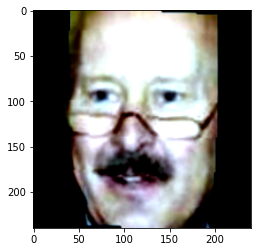

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


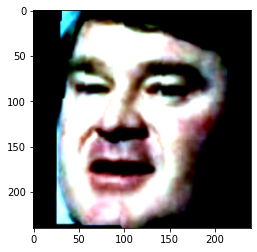

In [5]:
a, p, n = next(iter(train_loader))

a = a[0].numpy().transpose([1,2,0])
plt.imshow(a)

In [6]:
for i in range(stop_n_layers):
  for parm in model.features[i].parameters():
    parm.requires_grad=False


In [7]:
train_losses=model_train.train(model,epochs=1000,learn_rate=0.001,train_loader=train_loader,cuda=False)

 epoch 1 [..........] time remaining = 86.14305


KeyboardInterrupt

